# Import libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist

# Torch dependencies
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn-darkgrid')

# Converting to CUDA
* PyTorch comes with the functionality to perform high performance computation on a GPU. To convert all of the computation from a CPU to a GPU, you have to use CUDA with Torch

In [2]:
# By default, torch perform computation on CPU
device = torch.device("cpu")

# If GPU is available, switch to CUDA
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('GPU is available')
else:
    print('GPU is not available')

GPU is available


#### Comparison between CPU and GPU computation in torch

In [3]:
cpu = torch.device('cpu')
gpu = torch.device('cuda')

# Compare the two devices on a simple matrix multiplication
a = torch.normal(0, 1, size=(10000, 5000))
b = torch.normal(0, 1, size=(5000, 2000))

# On CPU
a = a.to(cpu)
b = b.to(cpu)

start = time.time()
result = a @ b
print('Time taken on a GPU : ', time.time() - start, 's')

# On GPU
a = a.to(gpu)
b = b.to(gpu)

start = time.time()
result = a @ b
print('Time taken on a GPU : ', time.time() - start, 's')

Time taken on a GPU :  0.23096585273742676 s
Time taken on a GPU :  0.0024912357330322266 s


# Artificial Neural Networks (ANN)

### 1. What is a neural network ?
* A neural network is a system of neurons that is responsible for the "thinking" made by human. An artificial neural network is a computation system that is inspired by the structure of human's neural network and used to replicate our decision making process. The basic unit of a neural network is an artificial perceptron.
![Perceptron illustration](https://www.allaboutcircuits.com/uploads/articles/how-to-train-a-basic-perceptron-neural-network_rk_aac_image1.jpg)

* A basic neural network architecture consists of many artificial perceptrons :
![ANN illustration](https://www.researchgate.net/profile/Facundo-Bre/publication/321259051/figure/fig1/AS:614329250496529@1523478915726/Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o.png)

## 2. Train a simple neural network in pytorch

### 2.1. Define the network architecture

In [4]:
# Define a neural network as subclass of nn.Module
class ANN(nn.Module):
    def __init__(self, in_features, hidden=16, n_classes=10):
        super(ANN, self).__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=hidden)
        self.hidden_layer = nn.Linear(in_features=hidden, out_features=n_classes)
        self.output_layer = nn.Softmax(dim=1)
        
    def forward(self, inputs):
        outputs = self.input_layer(inputs)
        outputs = self.hidden_layer(outputs)
        outputs = self.output_layer(outputs)
        
        return outputs
    
x = torch.normal(0, 1, size=(4, 12))
model = ANN(12, hidden=8, n_classes=2)
model(x).shape

torch.Size([4, 2])

### 2.2. Build a data loader

#### 2.2.1. Load the data from CSV file

In [5]:
# Read data from csv file and rename columns
data = pd.read_csv('../datasets/wine.csv')
data = data.rename(columns={'OD280/OD315 of diluted wines':'protein'})

data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,protein,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# Select features based on correlation matrix
corr_matrix = data.corr()
class_corr = corr_matrix['Class']

# Sort the correlations
sorted_corr = class_corr.apply(lambda x : abs(x)).sort_values()

# Pick top k attributes
top_k = 12
columns = list(sorted_corr.index)[-1-top_k:-1]
features = data[columns].values

# One hot encode the targets
targets = data['Class'].values.reshape(-1, 1) # vector form
targets = OneHotEncoder().fit_transform(targets).toarray()

#### 2.2.2. Create a pytorch data loader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        
        # Standard scaling the features
        mean = x.mean(axis=0, keepdim=True)
        std = x.std(axis=0, keepdim=True)
        
        x = (x - mean)/std
        
        return x, y
    
    def __len__(self):
        return len(self.features)
    
dataset = CustomDataset(features, targets)
loader = DataLoader(dataset, batch_size=16)

### 2.3. Define a training loop

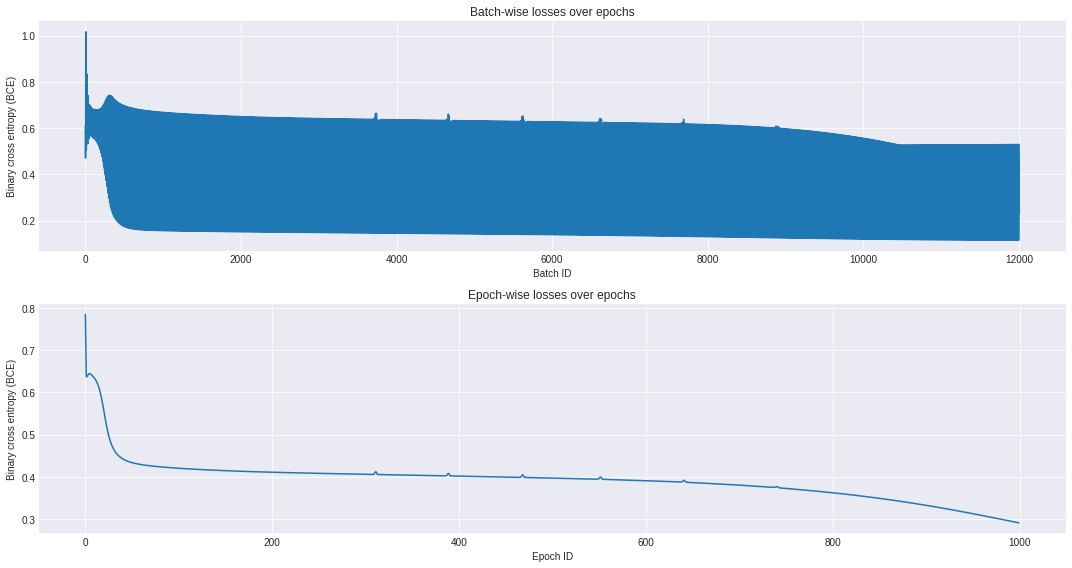

In [8]:
n_classes = targets.shape[-1]
model = ANN(features.shape[1], hidden=8, n_classes=n_classes)
def train(model, features, targets, epochs=1000):
    n_classes = targets.shape[-1]
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    dataset = CustomDataset(features, targets)
    loader = DataLoader(dataset, batch_size=16)

    # Convert my model to CUDA
    model = model.to(device)
    losses = []
    mean_losses = []
    for i in range(epochs):
        batch_losses = []
        for j, (X, Y) in enumerate(loader):
            # Clear gradients
            optimizer.zero_grad()

            # Convert our tensors to GPU
            X = X.to(device)
            Y = Y.to(device)

            outputs = model(X)
            loss = criterion(outputs, Y)
            losses.append(loss.cpu().detach().numpy())
            batch_losses.append(loss.cpu().detach().numpy())

            # Back propagation
            loss.backward()
            optimizer.step()

            # print('Epoch #', i+1, ', Batch #', j+1, ' Loss = ', loss.cpu().detach().numpy())

        # Get the mean loss for this epoch
        mean_losses.append(np.array(batch_losses).mean())

    fig, ax = plt.subplots(2,1, figsize=(15, 8))
    ax[0].plot(losses)
    ax[0].set_xlabel('Batch ID')
    ax[0].set_ylabel('Binary cross entropy (BCE)')
    ax[0].set_title('Batch-wise losses over epochs')

    ax[1].plot(mean_losses)
    ax[1].set_xlabel('Epoch ID')
    ax[1].set_ylabel('Binary cross entropy (BCE)')
    ax[1].set_title('Epoch-wise losses over epochs')
    plt.tight_layout()
    plt.show()
    
train(model, features, targets)

## 3. Activation functions
* If neural networks only consist of fully connected perceptrons activated by the dot product, the neural networks will become a linear model and would pretty much be useless learning non-linear patterns. To break this linearity nature, we have multiple activation functions to induce non-linearity:
![Activation functions](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

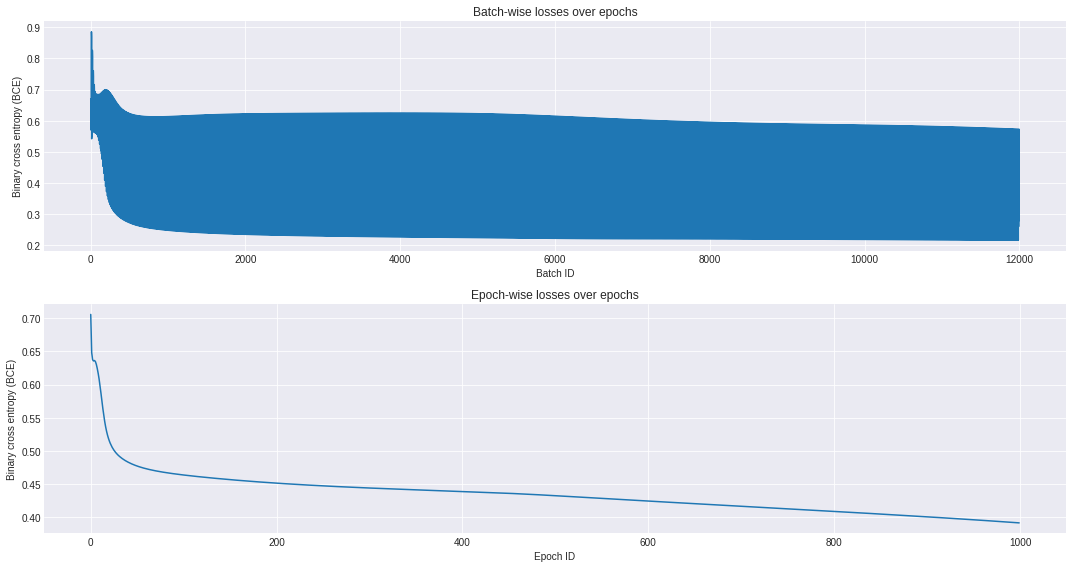

In [9]:
# Define a neural network with activation functions in the constructor
class ANNWithAct(nn.Module):
    def __init__(self, in_features, hidden=16, n_classes=10, activation=None):
        super(ANNWithAct, self).__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=hidden)
        self.hidden_layer = nn.Linear(in_features=hidden, out_features=n_classes)
        self.output_layer = nn.Softmax(dim=1)
        
        if(activation is not None):
            self.activation = activation
        else:
            self.activation = lambda x : x # return itself
        
    def forward(self, inputs):
        outputs = self.input_layer(inputs)
        outputs = self.activation(outputs)
        outputs = self.hidden_layer(outputs)
        outputs = self.activation(outputs)
        outputs = self.output_layer(outputs)
        
        return outputs
    
model = ANNWithAct(features.shape[-1], hidden=8, n_classes=targets.shape[-1], activation=nn.Tanh())
train(model, features, targets)

## 4. Batch normalization
* Batch normalization applies standardization on the activated outputs of the previous layer and the outcome will serve as the input for the present layer. The effect of batch normalization is to avoid "internal covariate shift", which basically implies chasing a constantly changing optimum in the optimization process. Hence, batch norm will likely to speed up your training time (requires less epochs)
![Batch norm formula](https://miro.medium.com/max/1086/1*hi4mPXONccxNm0Rxcrj-gg.png)

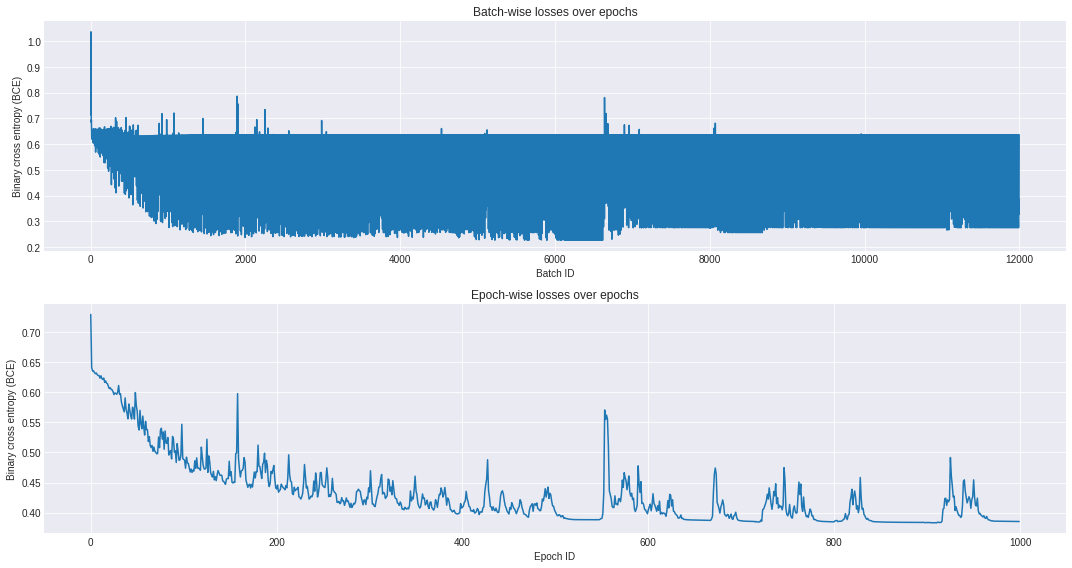

In [21]:
class ANNWithActAndNorm(nn.Module):
    def __init__(self, in_features, hidden=16, n_classes=10, activation=None):
        super(ANNWithActAndNorm, self).__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=hidden)
        self.bnorm1 = nn.BatchNorm1d(hidden)
        self.hidden_layer = nn.Linear(in_features=hidden, out_features=n_classes)
        self.bnorm2 = nn.BatchNorm1d(n_classes)
        self.output_layer = nn.Softmax(dim=1)
        
        if(activation is not None):
            self.activation = activation
        else:
            self.activation = lambda x : x # return itself
        
    def forward(self, inputs):
        outputs = self.input_layer(inputs)
        outputs = self.bnorm1(outputs)
        outputs = self.activation(outputs)
        
        outputs = self.hidden_layer(outputs)
        outputs = self.bnorm2(outputs)
        outputs = self.activation(outputs)
        
        outputs = self.output_layer(outputs)
        
        return outputs
    
model = ANNWithActAndNorm(features.shape[-1], hidden=8, n_classes=targets.shape[-1], activation=nn.Tanh())
train(model, features, targets, epochs=1000)